In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_absolute_error

# Load dataset MovieLens
ratings = pd.read_csv("dataset/ratings.csv")  # Đảm bảo có file này
movies = pd.read_csv("dataset/movies.csv")


# Chia tập train và test
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Xây dựng ma trận User-Item cho tập train
user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')

# Tính trung bình cộng ratings giữa các items
item_mean = user_item_matrix.mean(axis=0)

# Chuẩn hóa dữ liệu bằng cách trừ trung bình cộng ratings của mỗi item
user_item_matrix = user_item_matrix.sub(item_mean, axis=1).fillna(0)


item-item


In [5]:
item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(user_item_matrix.T)

NearestNeighbors(algorithm='brute', metric='cosine')

In [6]:
def get_similar_movies(movie_id, k=5):
    if movie_id not in user_item_matrix.columns:
        return "Movie ID không tồn tại trong dữ liệu"
    distances, indices = item_knn.kneighbors(user_item_matrix.T.loc[movie_id].values.reshape(1, -1), n_neighbors=k+1)
    similar_movies = [user_item_matrix.columns[i] for i in indices.flatten()[1:]]
    return movies[movies['movieId'].isin(similar_movies)]

user-user

In [7]:
# User-based Collaborative Filtering
user_knn = NearestNeighbors(metric='cosine', algorithm='brute')
user_knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [8]:
def get_similar_users(user_id, k=5):
    if user_id not in user_item_matrix.index:
        return "User ID không tồn tại trong dữ liệu"
    distances, indices = user_knn.kneighbors(user_item_matrix.loc[user_id].values.reshape(1, -1), n_neighbors=k+1)
    similar_users = [user_item_matrix.index[i] for i in indices.flatten()[1:]]
    return similar_users

In [9]:
def get_combined_recommendations(user_id, movie_id, k=5):
    similar_users = get_similar_users(user_id, k)
    similar_movies = get_similar_movies(movie_id, k)
    return {
        "similar_users": similar_users,
        "similar_movies": similar_movies
    }

In [10]:
# Thử nghiệm tìm phim tương tự
movie_id = 1  # Thay bằng ID phim bạn muốn kiểm tra
print(get_similar_movies(movie_id))

# Thử nghiệm tìm người dùng tương tự
user_id = 1  # Thay bằng ID người dùng bạn muốn kiểm tra
print(get_similar_users(user_id))

# Thử nghiệm kết hợp tìm người dùng và phim tương tự
print(get_combined_recommendations(user_id, movie_id))

      movieId                                           title  \
506       588                                  Aladdin (1992)   
1052     1367                           101 Dalmatians (1996)   
2052     2731  400 Blows, The (Les quatre cents coups) (1959)   
4360     6377                             Finding Nemo (2003)   
5374     8961                         Incredibles, The (2004)   

                                           genres  
506   Adventure|Animation|Children|Comedy|Musical  
1052                    Adventure|Children|Comedy  
2052                                  Crime|Drama  
4360          Adventure|Animation|Children|Comedy  
5374   Action|Adventure|Animation|Children|Comedy  
[72, 452, 498, 597, 122]
{'similar_users': [72, 452, 498, 597, 122], 'similar_movies':       movieId                                           title  \
506       588                                  Aladdin (1992)   
1052     1367                           101 Dalmatians (1996)   
2052     2731  

/Users/chi.nguyenth/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


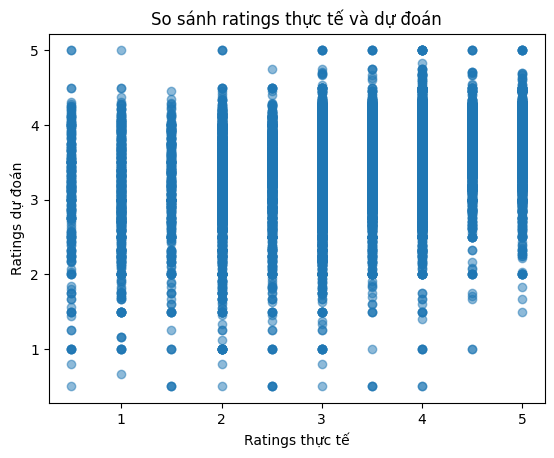

MSE: 0.9521683922864207, RMSE: 0.9757911622301263, MAE: 0.755290380089046


In [15]:
def evaluate_model():
    predictions = []
    actuals = []
    
    for _, row in test_data.iterrows():
        user_id, movie_id, actual_rating = row['userId'], row['movieId'], row['rating']
        if user_id in user_item_matrix.index and movie_id in user_item_matrix.columns:
            predicted_rating = item_mean[movie_id]  # Dự đoán bằng trung bình cộng
        else:
            predicted_rating = np.nan  # Không thể dự đoán
        
        if not np.isnan(predicted_rating):
            predictions.append(predicted_rating)
            actuals.append(actual_rating)
    
    mse = mean_squared_error(actuals, predictions)
    rmse = mean_squared_error(actuals, predictions, squared=False)
    mae = mean_absolute_error(actuals, predictions)
    
    # Vẽ biểu đồ so sánh ratings thực tế và dự đoán
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel("Ratings thực tế")
    plt.ylabel("Ratings dự đoán")
    plt.title("So sánh ratings thực tế và dự đoán")
    plt.show()
    
    return f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}"

print(evaluate_model())

In [14]:
user_id = 10  # Chọn user cụ thể
recommended_movies = get_similar_movies(movie_id=1, k=5)
print(f"Phim tương tự được đề xuất: {recommended_movies}")


Phim tương tự được đề xuất:       movieId                                           title  \
506       588                                  Aladdin (1992)   
1052     1367                           101 Dalmatians (1996)   
2052     2731  400 Blows, The (Les quatre cents coups) (1959)   
4360     6377                             Finding Nemo (2003)   
5374     8961                         Incredibles, The (2004)   

                                           genres  
506   Adventure|Animation|Children|Comedy|Musical  
1052                    Adventure|Children|Comedy  
2052                                  Crime|Drama  
4360          Adventure|Animation|Children|Comedy  
5374   Action|Adventure|Animation|Children|Comedy  
